In [1]:
from json import loads
from tqdm.notebook import tqdm

In [2]:
import numpy as np

In [3]:
import pandas as pd

Для построения рекомендательной системы выберем маленький датасет с данными об оценках товаров для животных: https://nijianmo.github.io/amazon/index.html

In [53]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

data = getDF('Pet_Supplies_5.json.gz')

In [54]:
data.head(3)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,3.0,2,True,"12 2, 2016",A2KN4FJVI2TZSF,0972585419,M.G.,I purchased this cd for my Pocket Parrot. It h...,It's okay,1480636800,NaN,NaN
1,3.0,NaN,True,"10 17, 2016",A3RMA1DD66JDRV,0972585419,Susan P.,"Maybe it's just my Amazon parrot, but she's no...",It might work for a different bird,1476662400,NaN,NaN
2,5.0,2,True,"09 9, 2016",AAANYRIEOIT3R,0972585419,Luggie Lugnut,I bought this to help me teach my blue quaker ...,I bought this to help me teach my blue quaker ...,1473379200,NaN,NaN


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2098325 entries, 0 to 2098324
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   vote            object 
 2   verified        bool   
 3   reviewTime      object 
 4   reviewerID      object 
 5   asin            object 
 6   reviewerName    object 
 7   reviewText      object 
 8   summary         object 
 9   unixReviewTime  int64  
 10  style           object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 194.1+ MB


Построение некоторых моделей требует очень большое количество памяти, поэтому уменьшим размер данных.

In [56]:
from random import randint

def reduce_data(proportion, data, column_name):
    initial_list = list(data[column_name].unique())
    new_data = pd.DataFrame()
    for item in tqdm(range(int(proportion*len(initial_list)))):
        element = initial_list[randint(0, len(initial_list) - 1)]
        new_data = pd.concat([new_data, data[data[column_name] == element]])
        initial_list.remove(element)
    return new_data

In [57]:
new_data = reduce_data(0.1, data, 'asin')

  0%|          | 0/4253 [00:00<?, ?it/s]

In [58]:
new_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
845624,5.0,4,False,"06 26, 2007",A3LPEHZ0YNKW5M,B001OVBAP8,Donna,"I tried this recently, and my dogs love it. T...",Four Paws Minty Fresh,1182816000,NaN,NaN
845632,5.0,NaN,True,"02 16, 2012",A1OXX0WGCEDEBY,B001OVBAP8,John,It took almost the whole bottle but my one dog...,Worked on my dog.,1329350400,NaN,NaN
845633,1.0,4,False,"01 14, 2012",A17N6UANMOY5V1,B001OVBAP8,Florida Papa,Google Four Paws recalls. [...] Search: Dog To...,Beware of Four Paws,1326499200,NaN,NaN
845644,5.0,NaN,True,"12 2, 2011",A262L9V3Q13ZRM,B001OVBAP8,Robert Cristofono,We've had good success with this product. The...,Dog Liquid Tartar Remover,1322784000,NaN,NaN
845645,5.0,5,True,"11 5, 2011",A12LH2100CKQO,B001OVBAP8,God is a refuge for us (Psalms 62:8),Amazon was the seller. I have used this produc...,so far so good,1320451200,NaN,NaN


In [59]:
new_data['reviewerID'].value_counts()

A11OTLEDSW8ZXD    50
A2GJX2KCUSR0EI    36
A22CW0ZHY3NJH8    34
A2503LT8PZIHAD    28
A2RYWPOL4NN2KG    27
                  ..
A2N9RQ9UGE3TQN     1
A1VRVG55O2GO17     1
A5SJ4110QM8YQ      1
A130VKD6760TV5     1
A13HTUNDQLTTZ3     1
Name: reviewerID, Length: 122765, dtype: int64

In [60]:
new_data['asin'].value_counts()

B0009YD8OC    6547
B000OX89XI    5262
B000XY7C7C    2957
B008PNN8DK    2530
B000L3XYZ4    2291
              ... 
B00175PG1A       4
B00DQ1QP7W       4
B000VZSSBW       2
B00176F8OE       2
B000YIYNZ6       1
Name: asin, Length: 4253, dtype: int64

In [61]:
new_data['overall'].value_counts()

5.0    133664
4.0     29034
3.0     17738
1.0     14042
2.0     10432
Name: overall, dtype: int64

<Axes: >

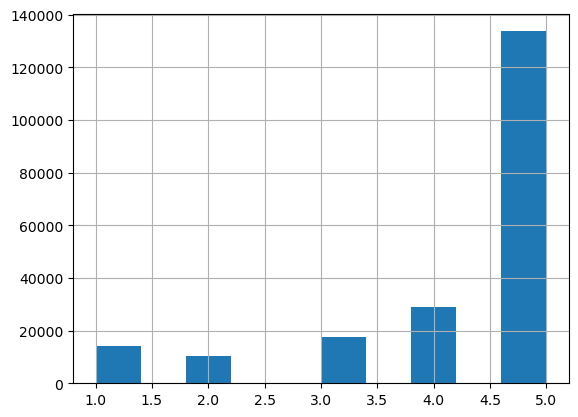

In [62]:
new_data['overall'].hist()

In [63]:
new_data.drop(['image', 'style', 'vote', 'reviewerName', 'reviewTime', 'verified', 'reviewText', 'summary'], axis=1, inplace=True)

In [64]:
new_data

,overall,reviewerID,asin,unixReviewTime
845624,5.0,A3LPEHZ0YNKW5M,B001OVBAP8,1182816000
845632,5.0,A1OXX0WGCEDEBY,B001OVBAP8,1329350400
845633,1.0,A17N6UANMOY5V1,B001OVBAP8,1326499200
845644,5.0,A262L9V3Q13ZRM,B001OVBAP8,1322784000
845645,5.0,A12LH2100CKQO,B001OVBAP8,1320451200
...,...,...,...,...
1073936,4.0,A13HTUNDQLTTZ3,B004X3VQ5I,1319068800
1073937,3.0,AYNTULRNAIPNY,B004X3VQ5I,1319068800
1073938,3.0,A34U4Y40W1GW9I,B004X3VQ5I,1317600000
2004538,5.0,A28X8HDZWHTVF8,B004X3VQ5I,1384992000


In [65]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204910 entries, 845624 to 2004539
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         204910 non-null  float64
 1   reviewerID      204910 non-null  object 
 2   asin            204910 non-null  object 
 3   unixReviewTime  204910 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 7.8+ MB


In [66]:
new_data.to_csv('tiny_data.csv', index=False)

# Train_test split

In [85]:
from math import ceil

def train_test_split(X, ratio=0.2, user_col='reviewerID', item_col='asin',
                     rating_col='overall', time_col='unixReviewTime'):
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)
    # список всех юзеров
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []
    for userId in tqdm(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        idx = ceil(curUser.shape[0] * (1 - ratio))

        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])
    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test

In [86]:
X_train, X_test, y_train, y_test = train_test_split(new_data)

  0%|          | 0/122765 [00:00<?, ?it/s]

In [87]:
X_train.head(3)

,reviewerID,asin
0,A1SYLII0808HD6,B000084F4A
1,A2VRB3RMM084I9,B0002AQO5S
2,A2VRB3RMM084I9,B0002AQO5S


In [88]:
train = pd.concat([X_train, pd.Series(y_train, name='rating')], axis=1)

In [89]:
test = pd.concat([X_test, pd.Series(y_test, name='rating')], axis=1)

In [90]:
train.describe()

,rating
count,201578.000000
mean,4.257965
std,1.222743
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [91]:
test.describe()

,rating
count,3332.000000
mean,4.280912
std,1.156225
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201578 entries, 0 to 201577
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewerID  201578 non-null  object 
 1   asin        201578 non-null  object 
 2   rating      201578 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.6+ MB


In [93]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3332 entries, 0 to 3331
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewerID  3332 non-null   object 
 1   asin        3332 non-null   object 
 2   rating      3332 non-null   float64
dtypes: float64(1), object(2)
memory usage: 78.2+ KB


In [94]:
train.to_csv('train.csv', index=False)

In [95]:
test.to_csv('test.csv', index=False)

# Построение моделей

Будем использовать коллаборативный подход, так как для контентного нет достаточно информации о товаре.

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [5]:
train_data

,reviewerID,asin,rating
0,A1SYLII0808HD6,B000084F4A,4.0
1,A2VRB3RMM084I9,B0002AQO5S,1.0
2,A2VRB3RMM084I9,B0002AQO5S,1.0
3,A3E752P9SWSH8S,B0002DJ7DQ,5.0
4,A3E752P9SWSH8S,B0002ASAXW,5.0
...,...,...,...
201573,A3817B1RBM4Z73,B01CVQQNQA,5.0
201574,A3HD9J5POYGBYI,B01CCP1UPY,5.0
201575,A17ELW72BAR179,B01F6O4PZ0,5.0
201576,ATHEZP7OA2GK0,B01HFAXVL2,5.0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201578 entries, 0 to 201577
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewerID  201578 non-null  object 
 1   asin        201578 non-null  object 
 2   rating      201578 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.6+ MB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3332 entries, 0 to 3331
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewerID  3332 non-null   object 
 1   asin        3332 non-null   object 
 2   rating      3332 non-null   float64
dtypes: float64(1), object(2)
memory usage: 78.2+ KB


In [8]:
train_data.describe()

,rating
count,201578.000000
mean,4.257965
std,1.222743
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [9]:
test_data.describe()

,rating
count,3332.000000
mean,4.280912
std,1.156225
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
from sklearn.metrics import mean_squared_error
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

# item-based на основе sklearn

Используем item-based подход, т.к число пользователей значительно больше.

In [67]:
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import cosine_similarity

class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col='userId', item_col='itemId'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()

        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()

        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])

        # создаём векторы для каждого предмета с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)

        # считаем попарную схожесть между предметами
        self.item_sim = cosine_similarity(self.item_ratings)

        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]
        return self

    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0

        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1

        return self.mean_y_item[pr_item] + numerator / denominator

    def predict(self, user, item):
        return (user, item, None, self.predict_rating(user, item))
    
    def predict_test(self, X, user_col='userId', item_col='itemId'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [68]:
X_train = train_data[['reviewerID', 'asin']]
y_train = train_data['rating']

In [69]:
X_test = test_data[['reviewerID', 'asin']]
y_test = test_data['rating']

In [70]:
%%time
print('start fitting...')
ib_model = ItemBased().fit(X_train, y_train, user_col='reviewerID', item_col='asin')

start fitting...
CPU times: user 1min 48s, sys: 53.7 s, total: 2min 42s
Wall time: 10min


In [71]:
print('start predicting...')
pred = ib_model.predict_test(X_test, user_col='reviewerID', item_col='asin')

start predicting...


In [72]:
na_list = pred[pred.isna()].index

In [17]:
true = y_test.copy()

In [18]:
true = true.drop(index=na_list, axis=0)

In [19]:
pred = pred.dropna()

In [20]:
print('result prediction')
print('rmse = {}'.format(rmse(true, pred)))

result prediction
rmse = 1.097652386213751


# surprise

Используем возможности библиотеки surprise

In [21]:
train_data.head()

,reviewerID,asin,rating
0,A1SYLII0808HD6,B000084F4A,4.0
1,A2VRB3RMM084I9,B0002AQO5S,1.0
2,A2VRB3RMM084I9,B0002AQO5S,1.0
3,A3E752P9SWSH8S,B0002DJ7DQ,5.0
4,A3E752P9SWSH8S,B0002ASAXW,5.0


In [24]:
from surprise import accuracy, Reader, Dataset

In [25]:
reader = Reader(line_format='user item rating', rating_scale=(1, 5))
surprise_train_data = Dataset.load_from_df(train_data, reader)

In [26]:
surprise_test_data = test_data.copy()
surprise_test_data['rating'] = 0

In [27]:
surprise_test_data

,reviewerID,asin,rating
0,A3E752P9SWSH8S,B0002DI3TK,0
1,A2RATH5QG78TYE,B01AUGT7RU,0
2,A3GQKB1KF0CRPE,B000F0DUPC,0
3,A2PNOU7NXB1JE4,B00B9GKQQM,0
4,A1WT40TFTG5YN9,B0009YD8OC,0
...,...,...,...
3327,A2DDULOQEIQO2I,B00EAN1USY,0
3328,A3HU3PA33FNCWS,B000MI3QYM,0
3329,A1IYBCK39L1Q9H,B001ODZ70A,0
3330,A3TSD2MXBGVP4N,B007XS26SG,0


In [28]:
surprise_test_data = Dataset.load_from_df(test_data, reader)

In [29]:
trainset = surprise_train_data.build_full_trainset()

In [30]:
testset = surprise_test_data.build_full_trainset().build_testset()

## Baseline

In [31]:
from surprise.prediction_algorithms.baseline_only import BaselineOnly

In [32]:
base_line_model = BaselineOnly()

In [33]:
base_line_model.fit(trainset)

Estimating biases using als...


In [34]:
base_line_test_prediction = base_line_model.test(testset)

In [35]:
accuracy.rmse(base_line_test_prediction)

RMSE: 1.0909


1.0909005817174278

## SVD

In [36]:
from surprise import SVD

In [37]:
svd_model = SVD()

In [38]:
svd_model.fit(trainset)

In [39]:
svd_test_prediction = svd_model.test(testset)

In [40]:
accuracy.rmse(svd_test_prediction)

RMSE: 1.0573


1.0572538787436134

## SVDpp

In [41]:
from surprise.prediction_algorithms.matrix_factorization import SVDpp

In [42]:
svdpp_model = SVDpp()

In [43]:
svdpp_model.fit(trainset)

In [44]:
svdpp_test_prediction = svdpp_model.test(testset)

In [45]:
accuracy.rmse(svdpp_test_prediction)

RMSE: 1.0725


1.0724511897589477

## SlopeOne

In [46]:
from surprise.prediction_algorithms.slope_one import SlopeOne

In [47]:
s_one_model = SlopeOne()

In [48]:
s_one_model.fit(trainset)

In [49]:
s_one_test_prediction = s_one_model.test(testset)

In [50]:
accuracy.rmse(s_one_test_prediction)

RMSE: 1.2435


1.2434564918158002

## CoClustering

In [51]:
from surprise.prediction_algorithms.co_clustering import CoClustering

In [52]:
coclast_model = CoClustering()

In [53]:
coclast_model.fit(trainset)

In [54]:
coclast_test_prediction = coclast_model.test(testset)

In [55]:
accuracy.rmse(coclast_test_prediction)

RMSE: 1.1654


1.1653806521914793

# Сравним рекомендации разных моделей

In [76]:
coclast_test_prediction[0][1]

'B0002DI3TK'

In [56]:
def get_top_n(user, model, n=10):
    all_items = train_data['asin'].unique()
    results = []
    predictions = []
    for item in all_items:
        prediction = model.predict(user, item)
        if prediction[2] is None:
            predictions.append(prediction)
        else:
            predictions.append(None)
    predictions.sort(key=lambda element: element[3], reverse=True)
    result = [item[1] for item in predictions[:n]]
    return sorted(result)

In [57]:
def common_items(list_1, list_2): 
    common_list = []
    for element in list_1:
        try:
            match = list_2.index(element)
        except ValueError:
            match = None
        if match is not None:
            common_list.append(element)
    return common_list

In [141]:
def make_coded_list(items_list, dictionary):
    coded_list = []
    for item in items_list:
        coded_value = dictionary.get(item, None)
        coded_list.append(coded_value)
    return coded_list

In [142]:
def top_comparison(user):
    n = 20
    lists = [('baseline', get_top_n(user, base_line_model, n)),
            ('item_based', get_top_n(user, ib_model, n)),
            ('svd', get_top_n(user, svd_model, n)),
            ('svdpp', get_top_n(user, svdpp_model, n)),
            ('s_one', get_top_n(user, s_one_model, n)),
            ('coclast', get_top_n(user, coclast_model, n))]
    
    df = pd.DataFrame(index=[item[0] for item in lists], columns=[item[0] for item in lists])
    dictionary = dict(zip(train_data['asin'].unique(), range(len(train_data['asin'].unique()))))
    for list_1_num in range(len(lists)):
        for list_2_num in range(len(lists)):
            if list_1_num != list_2_num:
                list_1 = lists[list_1_num]
                list_2 = lists[list_2_num]
                raw_list = common_items(list_1[1], list_2[1])
                coded_list = make_coded_list(raw_list, dictionary)
                df[list_1[0]][list_2[0]] = coded_list
    return df

In [144]:
top_comparison('A3E752P9SWSH8S')

/tmp/ipykernel_86565/156804603.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return self.mean_y_item[pr_item] + numerator / denominator


,baseline,item_based,svd,svdpp,s_one,coclast
baseline,NaN,[627],"[1743, 1317, 840, 1019, 797, 261]","[261, 2716]",[],[796]
item_based,[627],NaN,[],[],[2],"[861, 1028]"
svd,"[1743, 1317, 840, 1019, 797, 261]",[],NaN,[261],[],[]
svdpp,"[261, 2716]",[],[261],NaN,"[26, 185, 38]",[]
s_one,[],[2],[],"[26, 185, 38]",NaN,[]
coclast,[796],"[861, 1028]",[],[],[],NaN


In [145]:
top_comparison('A17ELW72BAR179')

/tmp/ipykernel_86565/156804603.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return self.mean_y_item[pr_item] + numerator / denominator


,baseline,item_based,svd,svdpp,s_one,coclast
baseline,NaN,[627],"[1609, 1055, 627, 1162, 797, 3927]",[840],[16],[16]
item_based,[627],NaN,[627],[],[],[]
svd,"[1609, 1055, 627, 1162, 797, 3927]",[627],NaN,[2906],[],[]
svdpp,[840],[],[2906],NaN,[18],[18]
s_one,[16],[],[],[18],NaN,"[2, 6, 19, 18, 15, 14, 7, 16, 13]"
coclast,[16],[],[],[18],"[2, 6, 19, 18, 15, 14, 7, 16, 13]",NaN


In [146]:
top_comparison('A2PNOU7NXB1JE4')

/tmp/ipykernel_86565/156804603.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return self.mean_y_item[pr_item] + numerator / denominator


,baseline,item_based,svd,svdpp,s_one,coclast
baseline,NaN,[627],"[1055, 1019]",[],[16],[796]
item_based,[627],NaN,[],[873],[],"[861, 1028]"
svd,"[1055, 1019]",[],NaN,[1810],[],[]
svdpp,[],[873],[1810],NaN,[20],[2084]
s_one,[16],[],[],[20],NaN,[]
coclast,[796],"[861, 1028]",[],[2084],[],NaN


В связи с тем, что более детальный анализ качества результата невозможен из-за отсутствия интерпретируемой информации о товарах, можно выбрать модель SVD как основную (она дает много совпадений с baseline и она имеет самую низкую ошибку rmse. Также возможна совместная работа нескольких моделей, но тут тоже необходима интерпретируемость для подбора комбинации.